# Causal graph discovery

This notebook gives an overview of the causal graph discovery. We apply a conditional independence-based causal discovery framework, here the PC (Peter-Clark)
algorithm, which identifies spurious correlations (e.g. resulting from indirect links or common drivers) among the included variables. It determines the presence and absence of edges and their orientation in a DAG using conditional independence tests among all observed variables and VKT.    
    
We adopt tigramite's pcmci implementation (see [tigramite on github](https://github.com/jakobrunge/tigramite)) and apply the PC algorithm to data sampled equally across all cities.    
This notebook follows the structure:   
- [0 Imports](#0-imports)
- [1 Initialization of tigramite](#1-initialize-tigramite)
- [2 Running tigramite's pcmici](#2-running-tigramites-pcmici)

For a further introduction to causal graph discovery check out the [tigramite tutorials](https://github.com/jakobrunge/tigramite/tree/master/tutorials/causal_discovery) on github and f.e. [Runge et al 2019](https://www.nature.com/articles/s41467-019-10105-3) in Nature Communications. 


**Data availability:**  
The notebook uses a anonymized sample across all cities. All feature data can be downloaded as outlined in the manuscript section data availability.

**Questions or comments:**   
Feel free to open an issue in git or get in touch via wagner(at)mcc-berlin.de


# 0 Imports

In [2]:
import os, sys
import numpy as np
from matplotlib import pyplot as plt     
import sys
import pandas as pd
import pickle

# import utils from xml4uf
PROJECT_SRC_PATH = os.getcwd().rsplit('/',1)[0]+'/xml4uf'
sys.path.append(PROJECT_SRC_PATH)
from utils.utils import FEATURE_NAMES
from ml.dag_discovery import CausalGraphDiscovery
import utils.utils as utils
import utils.utils_ml as utils_ml
import utils.utils_causal as utils_causal
import tigramite.data_processing as pp
import tigramite.plotting as tp
from tigramite.pcmci import PCMCI
from tigramite.independence_tests.robust_parcorr import RobustParCorr

# root path is defined by user, either here or in 
# bin/env_config.yml
path_root = utils.get_path_root()

/Users/felix/opt/miniconda3/envs/causal_env/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/felix/opt/miniconda3/envs/causal_env/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# 1 Initialization of tigramite
The main pipeline executes the following steps:     
1. [Sample data (skipped)](#11-sample-data)
2. [Prepare for tigramite format](#12-prepare-for-tigramite)
3. [Investigate data dependencies](#13-investigate-data-dependencies)


### 1.1 Sample data (skipped)

In [3]:
# as we cannot share original data we take a preprocessed sample across all cities, 
# where all features + target are normalized to mean = 0 and standart dev = 1.
df = utils.load_pickle('sample_data_dag_discovery.pkl')
df.head()

,tractid,distance_m,ft_dist_cbd,ft_employment_access_v2_05,ft_pop_dense,ft_income_groups,ft_beta
0,0,-0.106154,1.400786,-0.364388,0.083333,-0.938162,-0.567683
1,1,0.034774,-0.397275,-0.185482,0.048181,-0.092329,-0.307512
2,2,0.077734,0.269748,-0.507136,-0.649356,1.674464,-0.596622
3,3,-0.953476,-0.792667,-0.531340,-0.134824,0.055452,2.141151
4,4,0.503682,0.408196,-0.564190,-0.546924,1.263902,0.144431


### 1.2 Prepare for tigramite

In [4]:
# for easier display we rename variables
feature_names = {'distance_m':'y',
                'ft_dist_cbd':'x1',
                'ft_employment_access_v2_05':'x2',
                'ft_pop_dense':'x3',
                'ft_income_groups':'x4',
                'ft_beta':'x5',
                }

df_tmp = df.drop(columns=['tractid'])
var_names = [feature_names[var] for var in list(df_tmp.columns.values)]        
tigramite_df = pp.DataFrame(df_tmp.values, var_names=var_names)

### 1.3 Investigate data dependencies

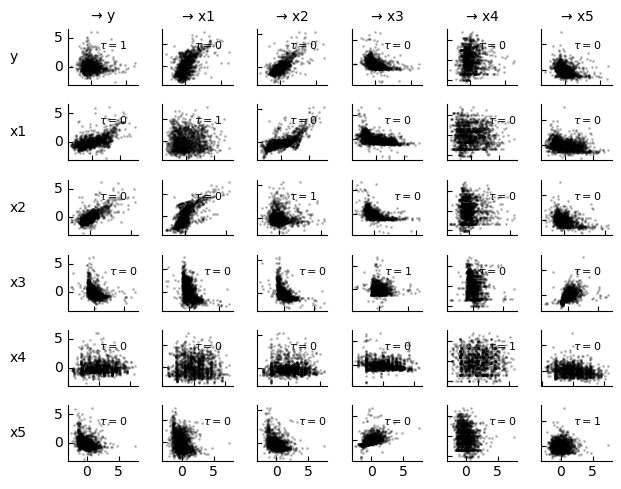

In [5]:
# Using scatter plots
tp.plot_scatterplots(dataframe=tigramite_df,
                    add_scatterplot_args={'matrix_lags':None}); plt.show()

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN be

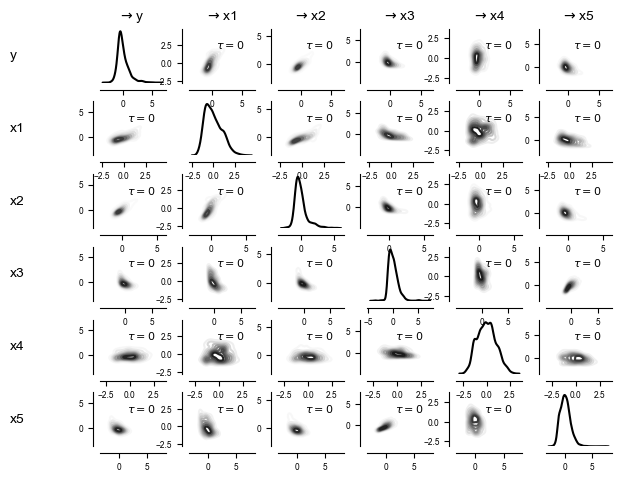

In [6]:
# Using density plots 
tp.plot_densityplots(dataframe=tigramite_df, add_densityplot_args={'matrix_lags':None})
plt.show()

# 2 Running tigramite's pcmici
Running tirgamite's pcmci supports various different condiditonal indepdence tests as well as adding expert assumptions.    
We first add expert assumptions and then run it.



### 2.1 Adding (expert) assumptions

In [7]:
# Setting (expert) assumptions:
# each key is a node in the dag whereas its items describe the direction of 
# the link ('o-o': unresolved/Markov equivalence,'<--': out of the node,
# '-->': into the node). At the beginning of a DAG discovery all links are set
# to 'o?o'.

# In addition, tigramite supports setting assumptions where:
# '-?>': link may not exist, but if it exists, its orientation is '-->'.
# '<?-': link may not exist, but if it exists, its orientation is '<--'.
# '<--': link exsists, its orientation is '<--'
# '-->': link exsists, its orientation is '-->'

# set assumptions (reasoning for choice of assumptions see Manuscript, Methods)
assumptions = ['x1',
            'y',
            'x4',
            ] 

# get list of all features
features = [ft for ft in var_names if 'x' in ft] 

#  initialize link assumptions
T,N = df_tmp.shape
link_assumptions = utils_causal.init_link_assumptions(N)

if 'x1' in assumptions: # distance to center (x1) can only cause other urban form features
    node_num = 1+features.index('x1')
    link_assumptions = utils_causal.set_node_links_soft(node_num,link_assumptions,into_node=False) 

if 'y' in assumptions: # VKT (y) can only be caused by urban form
    node_num = 0
    link_assumptions = utils_causal.set_node_links_soft(node_num,link_assumptions,into_node=True) 
    
if 'x4' in assumptions: # income (x4) can only be a confounder
    node_num = 1+features.index('x4')
    link_assumptions = utils_causal.set_node_links_soft(node_num,link_assumptions,into_node=False) 

link_assumptions

{0: {(1, 0): '-?>',
  (2, 0): '-?>',
  (3, 0): '-?>',
  (4, 0): '-?>',
  (5, 0): '-?>'},
 1: {(0, 0): '<?-',
  (2, 0): '<?-',
  (3, 0): '<?-',
  (4, 0): '-?>',
  (5, 0): '<?-'},
 2: {(0, 0): '<?-',
  (1, 0): '-?>',
  (3, 0): 'o?o',
  (4, 0): '-?>',
  (5, 0): 'o?o'},
 3: {(0, 0): '<?-',
  (1, 0): '-?>',
  (2, 0): 'o?o',
  (4, 0): '-?>',
  (5, 0): 'o?o'},
 4: {(0, 0): '<?-',
  (1, 0): '<?-',
  (2, 0): '<?-',
  (3, 0): '<?-',
  (5, 0): '<?-'},
 5: {(0, 0): '<?-',
  (1, 0): '-?>',
  (2, 0): 'o?o',
  (3, 0): 'o?o',
  (4, 0): '-?>'}}

### 2.2 Running pcmici with conditional independence test RobustParCorr

In [8]:
# set conditional independence test
cond_test = RobustParCorr(significance='analytic')

# init pcmci
pcmci = PCMCI(dataframe=tigramite_df, 
            cond_ind_test=cond_test,
            verbosity=0)

# run pcmci
results = pcmci.run_pcmciplus(tau_min=0, # as we don't have time series data
                            tau_max=0, # as we don't have time series data
                            pc_alpha=None, # can be provided as a list to optimize over, if None than default list
                            link_assumptions=link_assumptions)

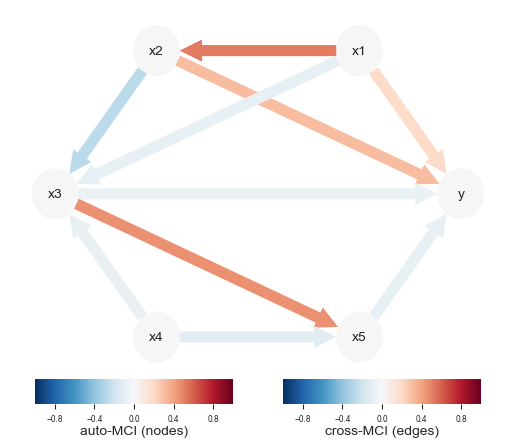

In [9]:
tp.plot_graph(val_matrix=results['val_matrix'],
                    graph=results['graph'],
                    var_names=var_names,
                    save_name = None,
                    link_colorbar_label='cross-MCI (edges)',
                    node_colorbar_label='auto-MCI (nodes)',
                    ); 